In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold

In [15]:
df = pd.read_excel('Data_Fatlim_Expanded_E.xlsx')
#df = df.dropna()
print(list(df.columns))
pdf = df[['s11a', 's22a', 's33a', 't12a', 't13a', 't23a', 's11m', 's22m', 's33m', 't12m', 't13m', 't23m', 'fi11', 'fi22', 'fi33', 'fi12', 'fi13', 'fi23', 'Rm', 'Re', 'f-1', 'f0', 't-1', 't0', 'walker_ann']]
print(pdf.shape)


train_dataset = pdf.sample(frac=0.95, random_state=1)
test_dataset = pdf.drop(train_dataset.index)

print(pdf.shape, train_dataset.shape, test_dataset.shape)

train_x = train_dataset.copy()
test_x = test_dataset.copy()
train_y = pd.DataFrame(train_x.pop('f-1'), columns = ['f-1']) 
test_y = pd.DataFrame(test_x.pop('f-1'), columns = ['f-1'])

phy_train_pdfy = pd.DataFrame(train_x.pop('walker_ann'), columns = ['walker_ann'])
phy_test_pdfy = pd.DataFrame(test_x.pop('walker_ann'), columns = ['walker_ann'])

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

x_train_tensor = torch.tensor(np.array(train_x), dtype=torch.float32).requires_grad_(True).to('cuda')
y_train_tensor = torch.tensor(np.array(train_y), dtype=torch.float32).requires_grad_(True).to('cuda')
x_test_tensor = torch.tensor(np.array(test_x), dtype=torch.float32).requires_grad_(True).to('cuda')

print(x_train_tensor.shape, y_train_tensor.shape)
print(x_test_tensor.shape)

['Trans', 'index', 'set', 's11a', 's22a', 's33a', 's11m', 's22m', 's33m', 't12a', 't13a', 't23a', 't12m', 't13m', 't23m', 'fi11', 'fi22', 'fi33', 'fi12', 'fi13', 'fi23', 'propo', 'Testing', 'mat', 'matgr', 'Rm', 'Re', 'f-1', 'f0', 'b-1', 'b0', 'rb-1', 't-1', 't0', 'Nx', 'gramWalker', 'gramWalker_ann', 'gramWalkerE_ann', 'mises_a', 'mises_m', 'mises', 'misesE', 'E_Mpa', 'poi', 'walkerE', 'walkerE_ann', 'walker_ann', 'walker', 'SWT', 'smith', 'soderberg', 'ASME', 'Bagci', 'Gerber', 'fNP_Bishop', 'fNP_Itoh', 'psi_max', 'S_eq', 'f-1_max', 'S_eq_mises_max', 'WS_a', 'WS_m']
(1732, 25)
(1732, 25) (1645, 25) (87, 25)
(1645, 23) (1645, 1)
(87, 23) (87, 1)
torch.Size([1645, 23]) torch.Size([1645, 1])
torch.Size([87, 23])


In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()

        #self.normalization = nn.BatchNorm1d(input_size)

        self.fc_layers = nn.Sequential(

            nn.Linear(input_size, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, output_size)
        )
    
    def forward(self, x):

        #out = self.normalization(x)
        out = self.fc_layers(x)

        return out

Epoch [1000/1000], Loss: 13.50 Validation MSE for fold 1: 16.91
Epoch [1000/1000], Loss: 13.41 Validation MSE for fold 2: 18.39
Epoch [1000/1000], Loss: 13.82 Validation MSE for fold 3: 18.67
Epoch [1000/1000], Loss: 14.24 Validation MSE for fold 4: 17.00
Epoch [1000/1000], Loss: 12.23 Validation MSE for fold 5: 17.73
Epoch [1000/1000], Loss: 13.01 Validation MSE for fold 6: 16.92
Average MSE: 17.60


(182.12425231933594, 556.3220825195312)

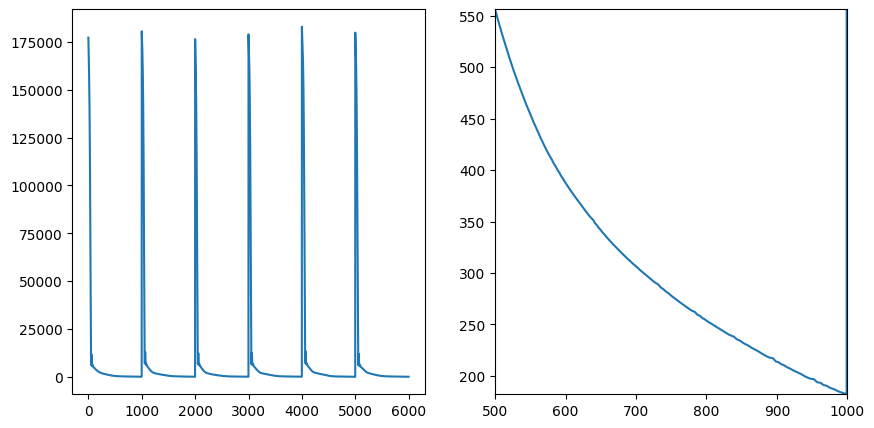

In [17]:
seed = 777
torch.manual_seed(seed)

lossesNN = []
lossesPhy = []
total_losses = []

kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f"FOLD {fold + 1} ",end='')

    X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
    y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]


    model = NeuralNetwork(23, 1).to('cuda')
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Se_pred = model(X_train.to('cuda'))
        loss1 = loss(Se_pred, y_train.to('cuda'))
        lossesNN.append(loss1.item())
        loss1.backward(retain_graph=True)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'\rEpoch [{epoch + 1}/{epochs}], Loss: {(loss1.item())**0.5:.2f}', end=' ')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to('cuda'))
        val_loss = loss(val_outputs, y_val.to('cuda'))
        results.append(val_loss**0.5)
        print(f"Validation MSE for fold {fold + 1}: {val_loss**0.5:.2f}")

results = [result.cpu().numpy() for result in results]
results = np.array(results)

average_mse = np.mean(results)
print(f"Average MSE: {average_mse:.2f}")



fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

axs[1].plot(lossesNN, label='Training Loss')
axs[1].set_xlim((epochs*0.5), epochs)
axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])
#axs[1].set_ylim( lossesNN[int(epochs*0.1)] , int(lossesNN[epochs-1]))


Text(10, 80, 'Std: 4.300')

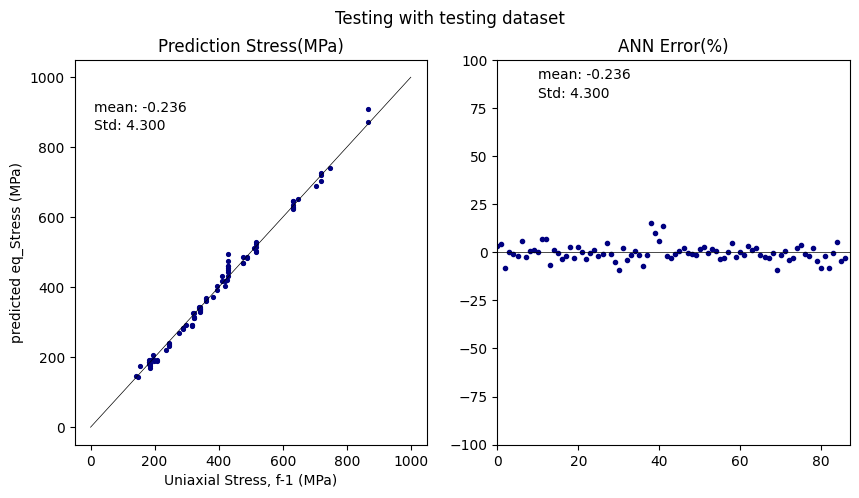

In [18]:
with torch.no_grad():
    output = model(x_test_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(test_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Testing with testing dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='navy')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(10,900,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(10,850,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)
axs[0].set(xlabel='Uniaxial Stress, f-1 (MPa)', ylabel='predicted eq_Stress (MPa)')

axs[1].plot(prediction['error(%)'] ,'.', color='navy')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, test_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

Text(10, 80, 'Std: 4.923')

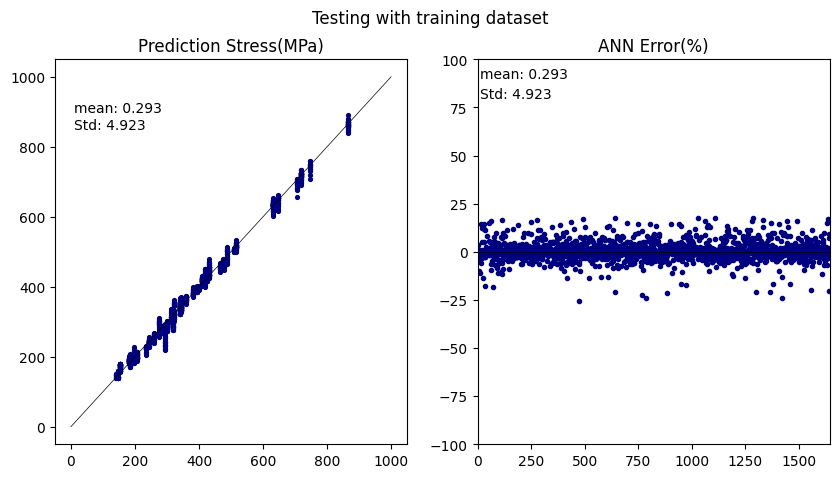

In [19]:
with torch.no_grad():
    output = model(x_train_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(train_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Testing with training dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='navy')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(10,900,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(10,850,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='navy')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, train_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

PINN

In [20]:
Physic_tensor = torch.tensor(np.array(phy_train_pdfy), dtype=torch.float32).to('cuda')
Physic_tensor = Physic_tensor.view(phy_train_pdfy.shape[0], 1)
print(Physic_tensor.shape)

torch.Size([1645, 1])


Epoch [1000/1000], Loss: 26.71 NNL: 18.75, PHYL: 19.02 Validation MSE for fold 1: 22.12
Epoch [1000/1000], Loss: 26.88 NNL: 18.76, PHYL: 19.25 Validation MSE for fold 2: 21.99
Epoch [1000/1000], Loss: 27.87 NNL: 19.01, PHYL: 20.37 Validation MSE for fold 3: 23.15
Epoch [1000/1000], Loss: 27.33 NNL: 18.48, PHYL: 20.14 Validation MSE for fold 4: 21.63
Epoch [1000/1000], Loss: 27.24 NNL: 18.65, PHYL: 19.86 Validation MSE for fold 5: 22.00
Epoch [1000/1000], Loss: 27.22 NNL: 18.83, PHYL: 19.65 Validation MSE for fold 6: 20.67
Average MSE: 21.93


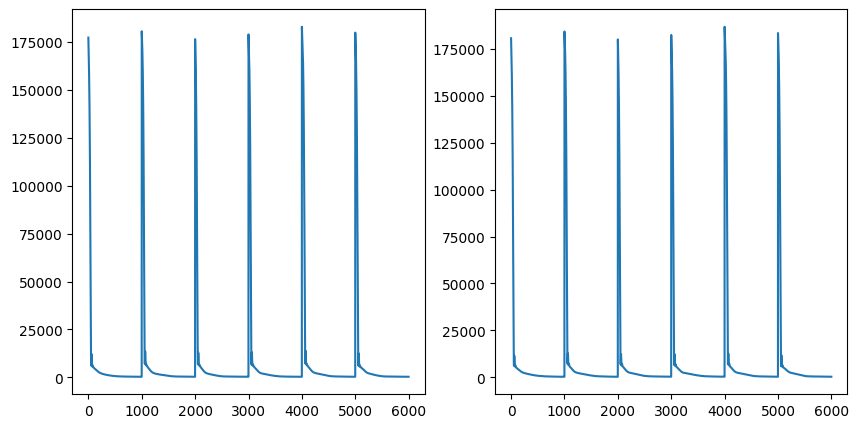

In [29]:
seed = 777
torch.manual_seed(seed)

lossesNN = []
lossesPhy = []
total_losses = []

kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f"FOLD {fold + 1} ",end='')

    X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
    y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
    y__phy_train, y_phy_val = Physic_tensor[train_index], Physic_tensor[val_index]

    model = NeuralNetwork(23, 1).to('cuda')
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Se_pred = model(X_train.to('cuda'))

        loss1 = loss(Se_pred, y_train.to('cuda'))
        loss2 = loss(Se_pred, y__phy_train.to('cuda'))
        total_loss = 1*loss1 + 1*loss2

        lossesNN.append(loss1.item())
        lossesPhy.append(loss2.item())
        #loss1.backward(retain_graph=True)
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'\rEpoch [{epoch+1}/{epochs}], Loss: {total_loss.item()**0.5:.2f} NNL: {loss1.item()**0.5:.2f}, PHYL: {loss2.item()**0.5:.2f}', end=' ')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to('cuda'))
        val_loss = loss(val_outputs, y_val.to('cuda'))
        results.append(val_loss**0.5)
        print(f"Validation MSE for fold {fold + 1}: {val_loss**0.5:.2f}")


results = [result.cpu().numpy() for result in results]
results = np.array(results)

average_mse = np.mean(results)
print(f"Average MSE: {average_mse:.2f}")



fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

#axs[1].plot(lossesNN, label='ANN Loss')
axs[1].plot(lossesPhy, label='PHY Loss')
#axs[1].set_xlim((epochs*0.5), epochs)
#axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])
#axs[1].set_ylim( lossesNN[int(epochs*0.1)] , int(lossesNN[epochs-1]))

           Y_pred         f-1   error(%)
count   87.000000   87.000000  87.000000
mean   394.218628  392.755233   0.235791
std    175.048904  171.451306   5.422662
min    144.253891  141.461202 -10.412977
25%    254.286537  259.753468  -2.526905
50%    358.413788  361.000000  -0.248999
75%    498.321243  482.687762   2.543536
max    904.917664  866.000000  23.298100


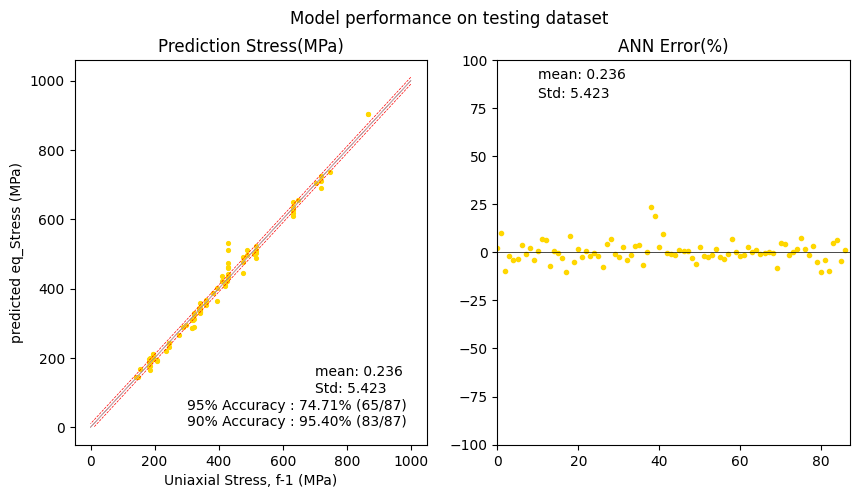

In [30]:
with torch.no_grad():
    output = model(x_test_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(test_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

temp_error = prediction['error(%)']
filtered_data5 = temp_error[(temp_error >= -5) & (temp_error <= 5)]
filtered_data10 = temp_error[(temp_error >= -10) & (temp_error <= 10)]

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Model performance on testing dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='gold')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(700,150,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(700,100,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)
axs[0].set(xlabel='Uniaxial Stress, f-1 (MPa)', ylabel='predicted eq_Stress (MPa)')
axs[0].plot([1000,0],[1000,0],'-',color='pink', linewidth=0.5)
axs[0].plot([1000,0],[1010,10],'--',color='red', linewidth=0.5)
axs[0].plot([1000,10],[990,0],'--',color='red', linewidth=0.5)
axs[0].text(300,50,f"95% Accuracy : {filtered_data5.count()/test_x.shape[0]*100:.2f}% ({filtered_data5.count()}/{test_x.shape[0]})",fontsize=10)
axs[0].text(300,5,f"90% Accuracy : {filtered_data10.count()/test_x.shape[0]*100:.2f}% ({filtered_data10.count()}/{test_x.shape[0]})",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='gold')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, test_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

print(prediction.describe())

Epoch [1000/1000], Loss: 16.00 NNL: 13.61, PHYL: 26.64 Validation MSE for fold 1: 17.00
Epoch [1000/1000], Loss: 16.35 NNL: 13.84, PHYL: 27.55 Validation MSE for fold 2: 19.01
Epoch [1000/1000], Loss: 16.91 NNL: 14.26, PHYL: 28.76 Validation MSE for fold 3: 19.02
Epoch [1000/1000], Loss: 17.01 NNL: 14.55, PHYL: 27.84 Validation MSE for fold 4: 17.35
Epoch [1000/1000], Loss: 15.59 NNL: 12.83, PHYL: 28.02 Validation MSE for fold 5: 18.14
Epoch [1000/1000], Loss: 16.68 NNL: 14.05, PHYL: 28.41 Validation MSE for fold 6: 17.79
Average MSE: 18.05


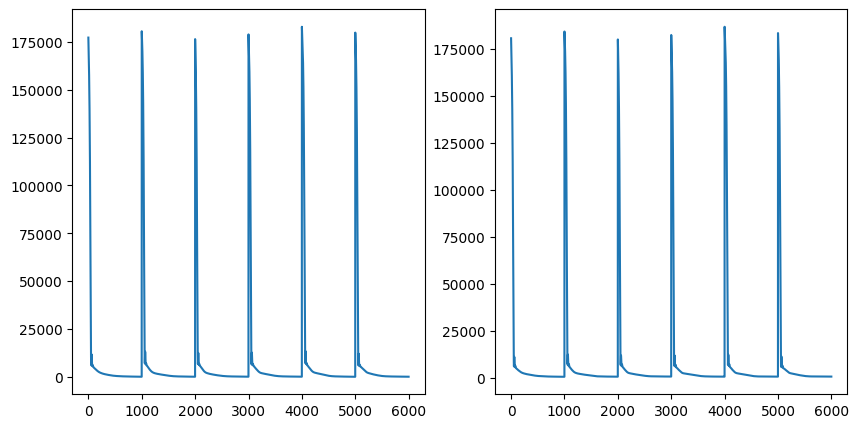

In [31]:
seed = 777
torch.manual_seed(seed)

lossesNN = []
lossesPhy = []
total_losses = []

kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f"FOLD {fold + 1} ",end='')

    X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
    y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
    y__phy_train, y_phy_val = Physic_tensor[train_index], Physic_tensor[val_index]

    model = NeuralNetwork(23, 1).to('cuda')
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Se_pred = model(X_train.to('cuda'))

        loss1 = loss(Se_pred, y_train.to('cuda'))
        loss2 = loss(Se_pred, y__phy_train.to('cuda'))
        total_loss = 1*loss1 + 0.1*loss2

        lossesNN.append(loss1.item())
        lossesPhy.append(loss2.item())
        #loss1.backward(retain_graph=True)
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'\rEpoch [{epoch+1}/{epochs}], Loss: {total_loss.item()**0.5:.2f} NNL: {loss1.item()**0.5:.2f}, PHYL: {loss2.item()**0.5:.2f}', end=' ')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to('cuda'))
        val_loss = loss(val_outputs, y_val.to('cuda'))
        results.append(val_loss**0.5)
        print(f"Validation MSE for fold {fold + 1}: {val_loss**0.5:.2f}")


results = [result.cpu().numpy() for result in results]
results = np.array(results)

average_mse = np.mean(results)
print(f"Average MSE: {average_mse:.2f}")



fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

#axs[1].plot(lossesNN, label='ANN Loss')
axs[1].plot(lossesPhy, label='PHY Loss')
#axs[1].set_xlim((epochs*0.5), epochs)
#axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])
#axs[1].set_ylim( lossesNN[int(epochs*0.1)] , int(lossesNN[epochs-1]))

           Y_pred         f-1   error(%)
count   87.000000   87.000000  87.000000
mean   393.480652  392.755233  -0.105422
std    175.560425  171.451306   4.642416
min    144.139069  141.461202  -9.406685
25%    255.140816  259.753468  -2.325395
50%    358.129120  361.000000  -0.489151
75%    489.197800  482.687762   1.917866
max    910.119690  866.000000  18.711417


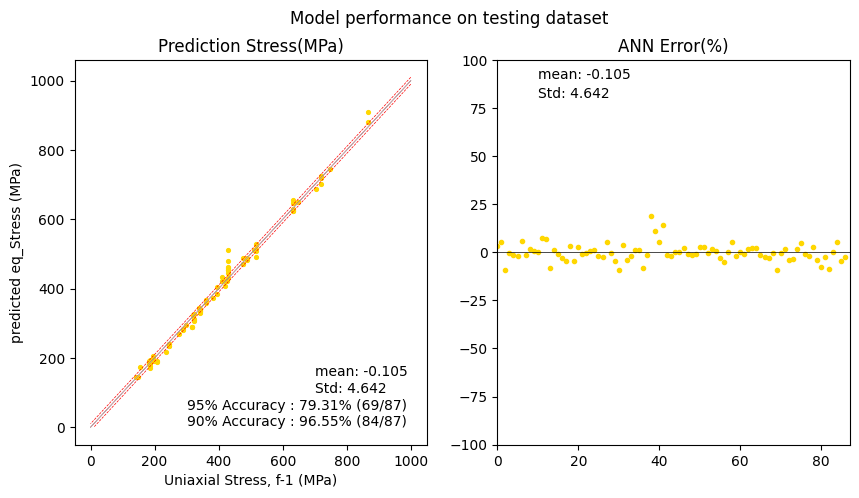

In [32]:
with torch.no_grad():
    output = model(x_test_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(test_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

temp_error = prediction['error(%)']
filtered_data5 = temp_error[(temp_error >= -5) & (temp_error <= 5)]
filtered_data10 = temp_error[(temp_error >= -10) & (temp_error <= 10)]

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Model performance on testing dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='gold')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(700,150,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(700,100,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)
axs[0].set(xlabel='Uniaxial Stress, f-1 (MPa)', ylabel='predicted eq_Stress (MPa)')
axs[0].plot([1000,0],[1000,0],'-',color='pink', linewidth=0.5)
axs[0].plot([1000,0],[1010,10],'--',color='red', linewidth=0.5)
axs[0].plot([1000,10],[990,0],'--',color='red', linewidth=0.5)
axs[0].text(300,50,f"95% Accuracy : {filtered_data5.count()/test_x.shape[0]*100:.2f}% ({filtered_data5.count()}/{test_x.shape[0]})",fontsize=10)
axs[0].text(300,5,f"90% Accuracy : {filtered_data10.count()/test_x.shape[0]*100:.2f}% ({filtered_data10.count()}/{test_x.shape[0]})",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='gold')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, test_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

print(prediction.describe())

Text(10, 80, 'Std: 4.904')

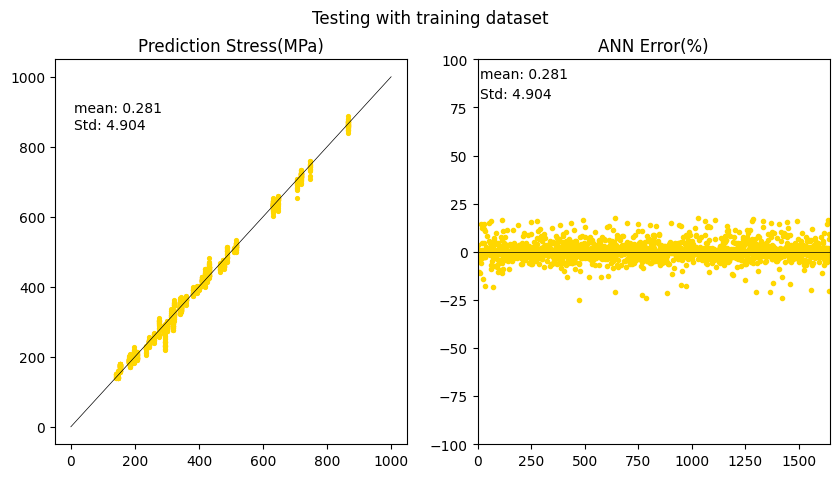

In [10]:
with torch.no_grad():
    output = model(x_train_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(train_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Testing with training dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='gold')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(10,900,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(10,850,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='gold')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, train_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

In [24]:
Lamda = [0, 1e-2, 1e-1, 1e0, 1e1]

stati_std = np.zeros((len(Lamda),len(Lamda)))
stati_mean = np.zeros((len(Lamda),len(Lamda)))
i = 0

for L1 in (Lamda):
    for L2 in (Lamda):
        
        i += 1

        seed = 777
        torch.manual_seed(seed)

        lossesNN = []
        lossesPhy = []
        total_losses = []

        kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
        results = []

        for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
            print(f"FOLD {fold + 1} ",end='')

            X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
            y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
            y__phy_train, y_phy_val = Physic_tensor[train_index], Physic_tensor[val_index]

            model = NeuralNetwork(23, 1).to('cuda')
            loss = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            epochs = 1000
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                Se_pred = model(X_train.to('cuda'))

                loss1 = loss(Se_pred, y_train.to('cuda'))
                loss2 = loss(Se_pred, y__phy_train.to('cuda'))
                total_loss = L1*loss1 + L2*loss2

                lossesNN.append(loss1.item())
                lossesPhy.append(loss2.item())
                #loss1.backward(retain_graph=True)
                total_loss.backward(retain_graph=True)
                optimizer.step()

            if (epoch+1) % 100 == 0:
                print(f'\rcase {i} of {len(Lamda)**2} Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.2f} NNL: {loss1.item():.2f}, PHYL: {loss2.item():.2f}', end=' ')
        
        with torch.no_grad():
            output = model(x_test_tensor)
            output = output.to('cpu')
        Y_pred = output.detach().numpy()

        pred = pd.DataFrame(Y_pred, columns = ['Y_pred'])
        pred['f-1'] = np.array(test_y)
        pred['error(%)'] = ((pred['Y_pred']-pred['f-1'])/pred['f-1'])*100
        error = np.array(pred['error(%)'])
        
        stati_std[Lamda.index(L1),Lamda.index(L2)] = np.std(error, ddof=1)
        stati_mean[Lamda.index(L1),Lamda.index(L2)] = np.mean(error)
    
        print(f'[ANN:{L1}, PHY:{L2}] - Std:{np.std(error, ddof=1):.2f} - mean:{np.mean(error):.2f}')

        #Y_pred = pd.DataFrame(np.array(Y_pred), columns = ['Y_pred'])
        #print(Y_pred.describe())

case 1 of 25 Epoch [1000/1000], Loss: 0.00 NNL: 179722.67, PHYL: 183247.50 [ANN:0, PHY:0] - Std:0.07 - mean:-99.90
case 2 of 25 Epoch [1000/1000], Loss: 2.21 NNL: 878.90, PHYL: 221.44 [ANN:0, PHY:0.01] - Std:6.75 - mean:0.45
case 3 of 25 Epoch [1000/1000], Loss: 21.91 NNL: 875.56, PHYL: 219.11 [ANN:0, PHY:0.1] - Std:6.69 - mean:0.60
case 4 of 25 Epoch [1000/1000], Loss: 219.42 NNL: 883.71, PHYL: 219.42 [ANN:0, PHY:1.0] - Std:6.71 - mean:0.44
case 5 of 25 Epoch [1000/1000], Loss: 2179.51 NNL: 880.65, PHYL: 217.95 [ANN:0, PHY:10.0] - Std:6.73 - mean:0.54
case 6 of 25 Epoch [1000/1000], Loss: 1.68 NNL: 167.60, PHYL: 906.82 [ANN:0.01, PHY:0] - Std:4.30 - mean:-0.35
case 7 of 25 Epoch [1000/1000], Loss: 7.70 NNL: 369.56, PHYL: 400.58 [ANN:0.01, PHY:0.01] - Std:5.48 - mean:0.53
case 8 of 25 Epoch [1000/1000], Loss: 30.23 NNL: 762.68, PHYL: 226.03 [ANN:0.01, PHY:0.1] - Std:6.54 - mean:0.64
case 9 of 25 Epoch [1000/1000], Loss: 230.16 NNL: 864.50, PHYL: 221.51 [ANN:0.01, PHY:1.0] - Std:6.75 - 

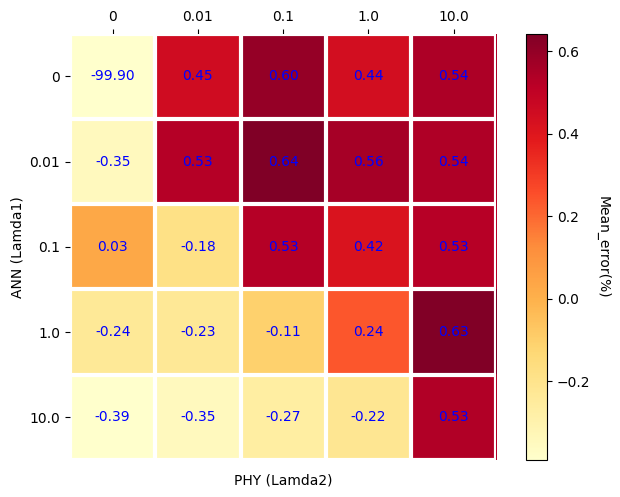

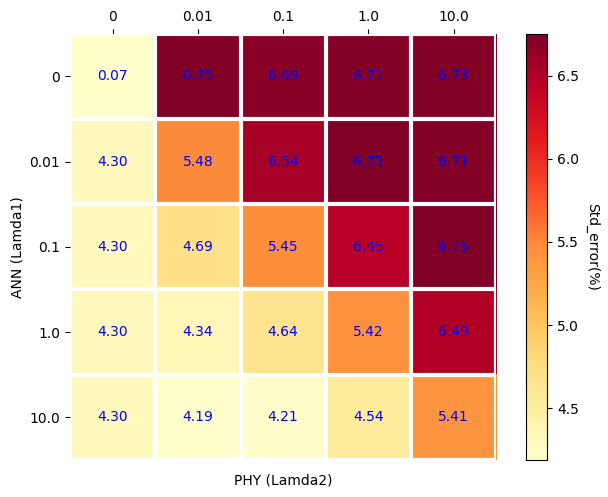

In [26]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar
###########################################################################################
ANN = Lamda
PHY = Lamda

vmin_mean = np.min(stati_mean[1:])
vmax_mean = np.max(stati_mean[1:])

vmin_std = np.min(stati_std[1:])
vmax_std = np.max(stati_std[1:])

figA, ax = plt.subplots()

im, cbar = heatmap(stati_mean, PHY, ANN, ax=ax,
                   cmap="YlOrRd", cbarlabel="Mean_error(%)", vmin = vmin_mean, vmax = vmax_mean)

for i in range(len(ANN)):
    for j in range(len(PHY)):
        text = ax.text(j, i, f'{stati_mean[i, j]:.2f}',ha="center", va="center", color="b")

figA.tight_layout()
plt.xlabel('PHY (Lamda2)',size = 10)
plt.ylabel('ANN (Lamda1)',size = 10)
plt.show()

figB, ax = plt.subplots()

im, cbar = heatmap(stati_std, PHY, ANN, ax=ax,
                   cmap="YlOrRd", cbarlabel="Std_error(%)", vmin = vmin_std, vmax = vmax_std)

for i in range(len(ANN)):
    for j in range(len(PHY)):
        text = ax.text(j, i, f'{stati_std[i, j]:.2f}',ha="center", va="center", color="b")

figB.tight_layout()
plt.xlabel('PHY (Lamda2)',size = 10)
plt.ylabel('ANN (Lamda1)',size = 10)
plt.show()

